<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Downloading .py Files

In [1]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("utils.py").is_file():
  print("utils.py already exists, skipping download")
else:
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/utils.py")
  with open("utils.py", "wb") as f:
    f.write(request.content)
  print("Downloaded utils.py.")

Downloaded utils.py.


# 2. Downloading Data

In [2]:
import gdown

id = "1WkN9LN_j0lfslSX0qC0Jlgf9bnluGSEu"
gdown.download_folder(id=id, quiet=True, use_cookies=False)
import zipfile
from pathlib import Path
import os

data_path = Path("WHISPER/")
image_path = Path("data")

with zipfile.ZipFile(data_path / "C2Seg_AB.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "C2Seg_AB.zip")

Unzipping C2Seg_AB data...


# 3. Setting Models

In [3]:
import torch
import torchvision
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [4]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights,
                                             DeepLabV3_ResNet101_Weights,
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

In [5]:
import torchvision
import torch
from torchvision.models.segmentation.fcn import FCNHead

def get_model(model_name: str, channels: int=26, output_size:int= 14):
  if model_name.lower() not in ("resnet_50"):
    raise ValueError("'model_name' should be one of ('resnet_50')")

  if model_name == "resnet_50":
    model, transform = load_model(model_name)
    for param in model.parameters():
      param.requires_grad = False

    if channels != 3:
      new_layer = torch.nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, stride=2, padding=1)
      model.backbone.conv1 = torch.nn.Sequential(new_layer, model.backbone.conv1)

    model.aux_classifier = FCNHead(in_channels=1024, channels=output_size)
    model.classifier[4] = torch.nn.Conv2d(256, output_size, kernel_size=(1, 1), stride=(1, 1))
    return model, transform

In [6]:
def load_model(model_name: str):
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")

    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()

    # Warmup run

    _ = model(torch.randn(1, 3, 520, 520))

    return model, transforms

In [93]:
in_channels = 248

In [165]:
model_resnet_50, transforms = get_model('resnet_50', in_channels, 14)

In [95]:
!pip install torchinfo

In [96]:
from torchinfo import summary
summary(model=model_resnet_50,
        input_size=(1, in_channels, 128, 128), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                              [1, 248, 128, 128]   [1, 14, 128, 128]    --                   Partial
├─IntermediateLayerGetter (backbone)               [1, 248, 128, 128]   [1, 2048, 8, 8]      --                   Partial
│    └─Sequential (conv1)                          [1, 248, 128, 128]   [1, 64, 32, 32]      --                   Partial
│    │    └─Conv2d (0)                             [1, 248, 128, 128]   [1, 3, 64, 64]       6,699                True
│    │    └─Conv2d (1)                             [1, 3, 64, 64]       [1, 64, 32, 32]      (9,408)              False
│    └─BatchNorm2d (bn1)                           [1, 64, 32, 32]      [1, 64, 32, 32]      (128)                False
│    └─ReLU (relu)                                 [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
│    └─MaxPool2d (maxpool)        

# 3. Making Predictions With Untrained Model

## 3.1 Setting up device agnostic code

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3.2 Defining color-labels and visiualization functions

In [98]:
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

In [99]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).cpu().numpy()

    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.

    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_map)):
        index = labels == label_num

        R, G, B = label_map[label_num]

        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)

    return image

## 3.3 Defining Visualisation Functions

In [116]:
from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_and_show(model, dataset:data.Dataset, index):
  X, mask = dataset[index]
  X = X.to(device)
  model.eval()
  with torch.inference_mode():
    output = model(X.unsqueeze(dim=0))["out"].to(device)

  W, H = output.shape[2], output.shape[3]

  # Get RGB segmentation map
  segmented_image = draw_segmentation_map(output)

  # Resize to original image size
  segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
  #overlayed_image = image_overlay(img_raw, segmented_image)

  # Plot
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 3, 1)
  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  plt.title("Ground Truth")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.title("Segmentation")
  plt.axis("off")
  plt.imshow(segmented_image)

  plt.show()
  plt.close()
  # Save Segmented and overlayed images
  if False:
      cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
      cv2.imwrite(overlayed_save_dir, overlayed_image)

In [117]:
import random

from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_random_and_show(model, dataset:data.Dataset):
    indices = random.sample(range(len(dataset)), 6)  # Change max_index to the maximum index available in your dataset

    plt.figure(figsize=(20, 20))

    for idx, index in enumerate(indices, 1):
        X, mask = dataset[index]
        X = X.to(device)
        model.eval()
        with torch.inference_mode():
            output = model(X.unsqueeze(dim=0))["out"].to(device)

        W, H = output.shape[2], output.shape[3]

        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)

        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)

        plt.subplot(6, 3, 3 * (idx - 1) + 1)
        cmap = ListedColormap(label_map / 255.0)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)
        plt.title(f"Ground Truth - Image {index}")
        plt.axis("off")

        plt.subplot(6, 3, 3 * (idx - 1) + 2)
        plt.title(f"Segmentation - Image {index}")
        plt.axis("off")
        plt.imshow(segmented_image)

    plt.tight_layout()
    plt.show()
    plt.close()



In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def show_mask(mask):
  # Assuming you have your mask data in a NumPy array named "mask"
  # It should be a 128x128 image containing label values from 0 to 13.

  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  # Set the number of unique labels for the colorbar
  num_labels = len(label_map)

  # Set the tick positions and labels for the colorbar
  ticks = np.arange(num_labels)

  # Create the colorbar with the custom labels
  cbar = plt.colorbar(ticks=ticks)
  cbar.ax.set_yticklabels(labels, fontsize=8)
  plt.axis("off")
  # Show the plot
  plt.show()

# 4. Training Model

## 4.1 Defining Accuracy Metrics

In [102]:
def calculate_accuracy(pred, target):
    _, predicted = torch.max(pred, 1)
    correct_pixels = (predicted == target).sum().item()
    total_pixels = target.numel()
    accuracy = correct_pixels / total_pixels * 100
    return accuracy

In [103]:
def calculate_f1(pred, target, num_classes):
    f1_list = []
    for class_id in range(num_classes):
        pred_mask = (pred == class_id)
        target_mask = (target == class_id)
        true_positive = (pred_mask & target_mask).sum().item()
        false_positive = (pred_mask & ~target_mask).sum().item()
        false_negative = (~pred_mask & target_mask).sum().item()
        precision = true_positive / (true_positive + false_positive + 1e-8)
        recall = true_positive / (true_positive + false_negative + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # Add a small epsilon to avoid division by zero
        f1_list.append(f1)
    return sum(f1_list) / len(f1_list)

In [104]:
def calculate_iou(pred, target, num_classes):
    iou_list = []
    for class_id in range(num_classes):
        pred_mask = (pred == class_id)
        target_mask = (target == class_id)
        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()
        iou = intersection / (union + 1e-8)  # Add a small epsilon to avoid division by zero
        iou_list.append(iou)
    return sum(iou_list) / len(iou_list)

## 4.2 Splitting Train and Validation Data

In [105]:
data_count = 273

In [106]:
from sklearn.model_selection import train_test_split
indexes = list(range(data_count))
train_idx, val_idx = train_test_split(indexes, train_size=0.85)

len(train_idx), len(val_idx)

(232, 41)

## 4.3 Creating DataLoaders

In [107]:
import torch
from skimage.io import imread
from torch.utils import data
from utils import get_img

class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 indexes,
                 file_path='/content/data/C2Seg_AB/train',
                 transform=None,
                 ):
        self.file_path = file_path
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.transform = transform
        self.indexes = indexes

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self,
                    index: int):
        # Select the sample

        data_index = self.indexes[index]

        X, y = get_img(data_index, self.file_path, reduce_hsi=False, use_sar=True)
        X = torch.squeeze(X)
        # Preprocessing
        if self.transform is not None:
            X, y = self.transform(X, y)

        # Typecasting
        X, y = X.type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return X, y

In [108]:
training_dataset = SegmentationDataSet(indexes=train_idx)

training_dataloader = data.DataLoader(dataset=training_dataset,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(training_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 248, 128, 128]); type: torch.float32
x = min: -32.6815185546875; max: 13084.0
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [109]:
val_dataset = SegmentationDataSet(indexes=val_idx)

val_dataloader = data.DataLoader(dataset=val_dataset,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(val_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 248, 128, 128]); type: torch.float32
x = min: -31.438724517822266; max: 7020.0
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


## 4.4 Training Loop

In [110]:
def validate(model, val_dataloader, loss_fn):
  model.eval()  # Set the model to evaluation mode
  device = next(model.parameters()).device  # Get the device of the model's parameters

  val_loss = 0.0
  val_accuracy = 0.0
  val_iou = 0.0
  val_f1 = 0.0
  val_total = 0

  model.eval()
  with torch.inference_mode():
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs["out"], targets.long())

      val_loss += loss.item()

      accuracy = calculate_accuracy(outputs["out"], targets)
      iou = calculate_iou(torch.argmax(outputs["out"], dim=1), targets, num_classes=14)
      f1 = calculate_f1(torch.argmax(outputs["out"], dim=1), targets, num_classes=14)

      val_accuracy += accuracy
      val_iou += iou
      val_f1 += f1

      val_total += targets.size(0)

  mean_val_loss = val_loss / len(val_dataloader)
  mean_val_accuracy = val_accuracy / len(val_dataloader)
  mean_val_iou = val_iou / len(val_dataloader)
  mean_val_f1 = val_f1 / len(val_dataloader)

  return mean_val_loss, mean_val_accuracy, mean_val_iou, mean_val_f1

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_iou = 0.0
        running_f1 = 0.0

        loss_epoch = []
        acc_epoch = []
        iou_epoch = []
        f1_epoch = []

        for batch_idx, (inputs, targets) in enumerate(train_data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            accuracy = calculate_accuracy(outputs["out"], targets)
            iou = calculate_iou(torch.argmax(outputs["out"], dim=1), targets, 14)
            f1 = calculate_f1(torch.argmax(outputs["out"], dim=1), targets, num_classes=14)

            # Calculate the loss
            loss = loss_fn(outputs["out"], targets.long())  # Assuming targets are integer class labels
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy
            running_iou += iou
            running_f1 = f1

            if batch_idx % 10 == 9:  # Print every 10 mini-batches
                mean_loss = running_loss / 10
                mean_acc = running_acc / 10
                mean_iou = running_iou / 10
                mean_f1 = running_f1 / 10

                running_loss = 0.0
                running_acc = 0.0
                running_iou = 0.0
                running_f1 = 0.0

                loss_epoch.append(mean_loss)
                acc_epoch.append(mean_acc)
                iou_epoch.append(mean_iou)
                f1_epoch.append(mean_f1)


        print(f"Epoch {epoch + 1} | Train Loss: {(sum(loss_epoch) / len(loss_epoch)):.4f} | Train Accuracy: {(sum(acc_epoch) / len(acc_epoch)):.4f}% | Train mIOU: {(sum(iou_epoch) / len(iou_epoch)):.4f} | Train mF1: {(sum(f1_epoch) / len(f1_epoch)):.4f}")

        if val_data_loader != None:
          val_loss, val_accuracy, val_iou, val_f1 = validate(model, val_dataloader, loss_fn)
          print(f"Epoch {epoch + 1} | Val Loss: {val_loss:.4f}   | Val Accuracy: {val_accuracy:.4f}%   | Val mIOU: {val_iou:.4f}   | Val mF1: {val_f1:.4f}")
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"----- Epoch Time: {epoch_time:.2f}s -----")

num_epochs = 16

In [168]:
optimizer = optim.Adam(model_resnet_50.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs=50

train(model_resnet_50, training_dataloader, val_dataloader, loss_fn, optimizer, num_epochs)

Epoch 1 | Train Loss: 2.3921 | Train Accuracy: 18.1389% | Train mIOU: 0.0315 | Train mF1: 0.0061
Epoch 1 | Val Loss: 2.3008 | Val Accuracy: 18.7692% | Val mIOU: 0.0224 | Val mF1: 0.0393
----- Epoch Time: 14.29s -----
Epoch 2 | Train Loss: 2.2946 | Train Accuracy: 20.9426% | Train mIOU: 0.0314 | Train mF1: 0.0056
Epoch 2 | Val Loss: 2.2680 | Val Accuracy: 19.7689% | Val mIOU: 0.0301 | Val mF1: 0.0510
----- Epoch Time: 14.02s -----
Epoch 3 | Train Loss: 2.2409 | Train Accuracy: 21.4283% | Train mIOU: 0.0285 | Train mF1: 0.0054
Epoch 3 | Val Loss: 2.1598 | Val Accuracy: 24.7337% | Val mIOU: 0.0278 | Val mF1: 0.0454
----- Epoch Time: 14.62s -----
Epoch 4 | Train Loss: 2.1990 | Train Accuracy: 22.2967% | Train mIOU: 0.0287 | Train mF1: 0.0043
Epoch 4 | Val Loss: 2.1483 | Val Accuracy: 20.8332% | Val mIOU: 0.0224 | Val mF1: 0.0379
----- Epoch Time: 14.62s -----
Epoch 5 | Train Loss: 2.1535 | Train Accuracy: 23.8225% | Train mIOU: 0.0281 | Train mF1: 0.0037
Epoch 5 | Val Loss: 2.0814 | Val Ac

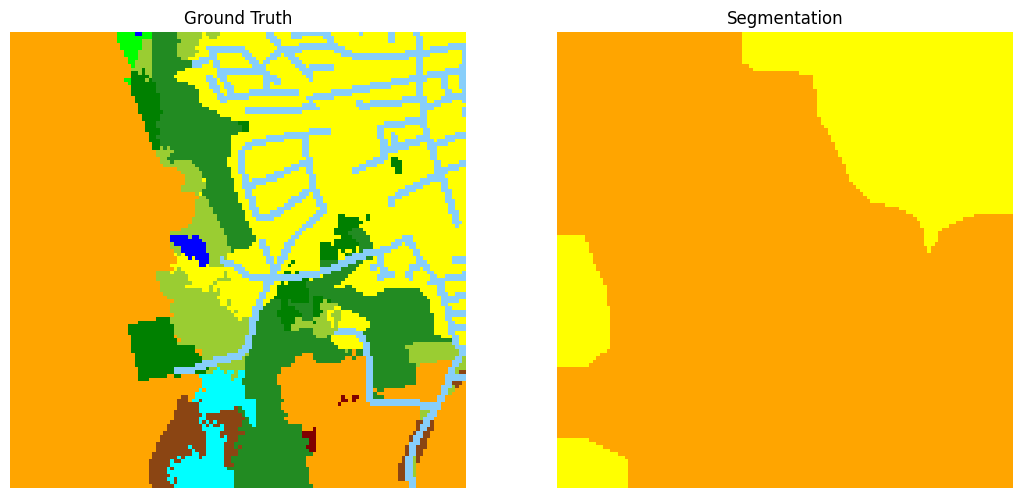

In [186]:
index = 0
predict_and_show(model_resnet_50, val_dataset, index)

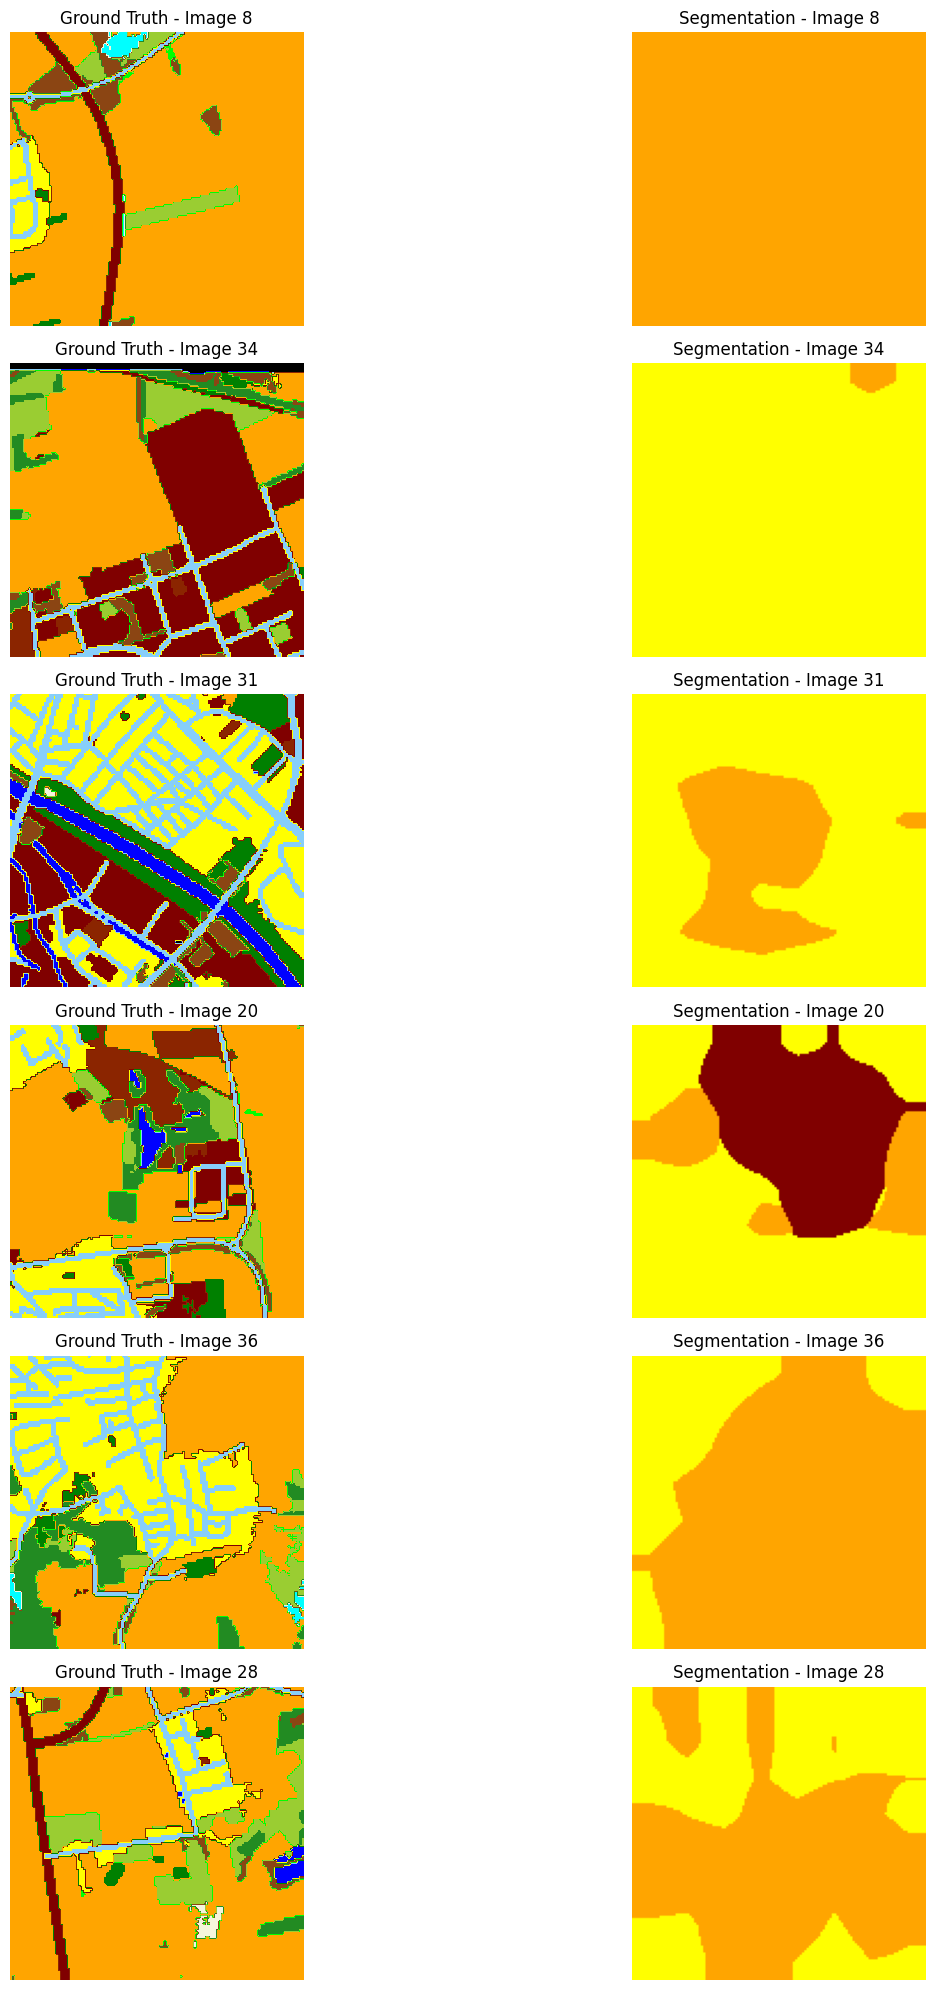

In [172]:
predict_random_and_show(model=model_resnet_50, dataset=val_dataset)

#5. Save The Base Model

In [174]:
torch.save(model_resnet_50, "models/resnet_50_base_248.pth")

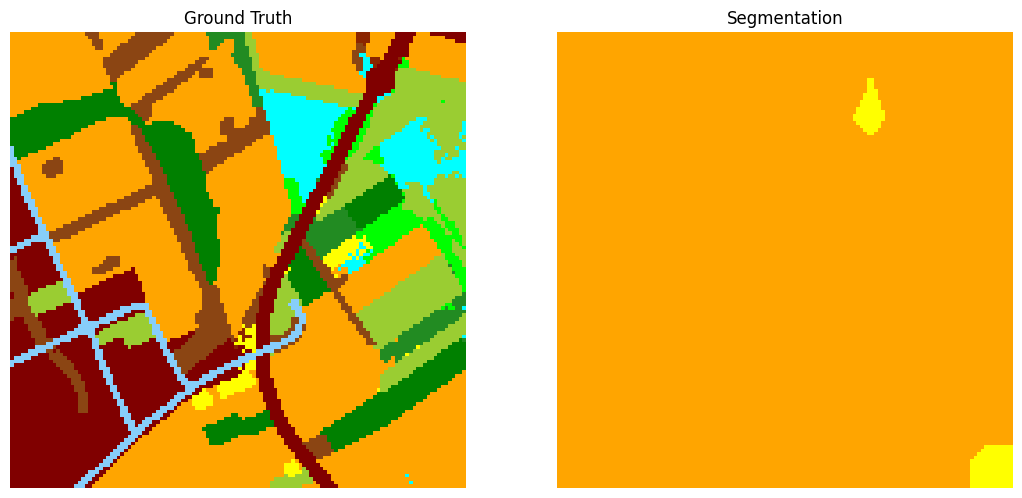

In [176]:
loaded_model = torch.load("models/resnet_50_base_248.pth")
predict_and_show(loaded_model, val_dataset, 10)

# 5. Trying Data Augmentation

In [157]:
import torch
import random

def custom_augmentation(tensor, mask=None):
  # Random flipping
  if random.random() < 0.5:
      tensor = torch.flip(tensor, [1])  # Flip vertically
      if mask != None:
        mask = torch.flip(mask.unsqueeze(dim=0), [1])
        mask = mask.squeeze()

  if random.random() < 0.5:
      tensor = torch.flip(tensor, [2])  # Flip horizontally
      if mask != None:
        mask = torch.flip(mask.unsqueeze(dim=0), [2])
        mask = mask.squeeze()

  if mask == None:
    return tensor
  else:
    return tensor, mask

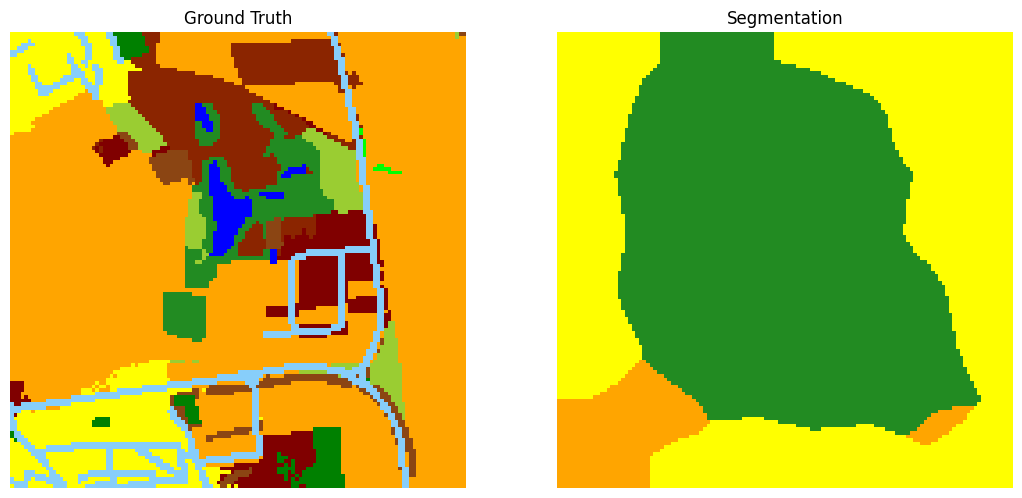

In [163]:
from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

model, dataset, index = model_resnet_50, val_dataset, 20

X, mask = dataset[index]
X, mask= custom_augmentation(X, mask)
X = X.to(device)
model.eval()
with torch.inference_mode():
  output = model(X.unsqueeze(dim=0))["out"].to(device)

W, H = output.shape[2], output.shape[3]

# Get RGB segmentation map
segmented_image = draw_segmentation_map(output)

# Resize to original image size
segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
#overlayed_image = image_overlay(img_raw, segmented_image)

# Plot
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
# Create a custom colormap using the colors defined above
cmap = ListedColormap(label_map / 255.0)

# Display the mask using the custom colormap
plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Segmentation")
plt.axis("off")
plt.imshow(segmented_image)

plt.show()
plt.close()
# Save Segmented and overlayed images
if False:
    cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
    cv2.imwrite(overlayed_save_dir, overlayed_image)

In [132]:
mask.size()

torch.Size([128, 128])